## Captum

* https://captum.ai/
* https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum

Captum a flexible, and easy-to-use model interpretability library for PyTorch models, providing state-of-the-art tools for understanding how specific neurons and layers affect predictions.

Captum includes a large number of different algorithms/methods which can be categorized into three main groups:

    General Attribution: Evaluates the contribution of each input feature to the output of a model.
    Layer Attribution: Evaluates the contribution of each neuron in a given layer to the output of the model.
    Neuron Attribution: Evaluates the contribution of each input feature on the activation of a particular hidden neuron.

In [ ]:
# !wget -O dog1.jpg https://www.rover.com/blog/wp-content/uploads/2011/11/german-shepherd-960x540.jpg

In [ ]:
# !wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [3]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

torch.manual_seed(0)
np.random.seed(0)

model = models.resnet18(pretrained=True)
model = model.eval()

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [4]:
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

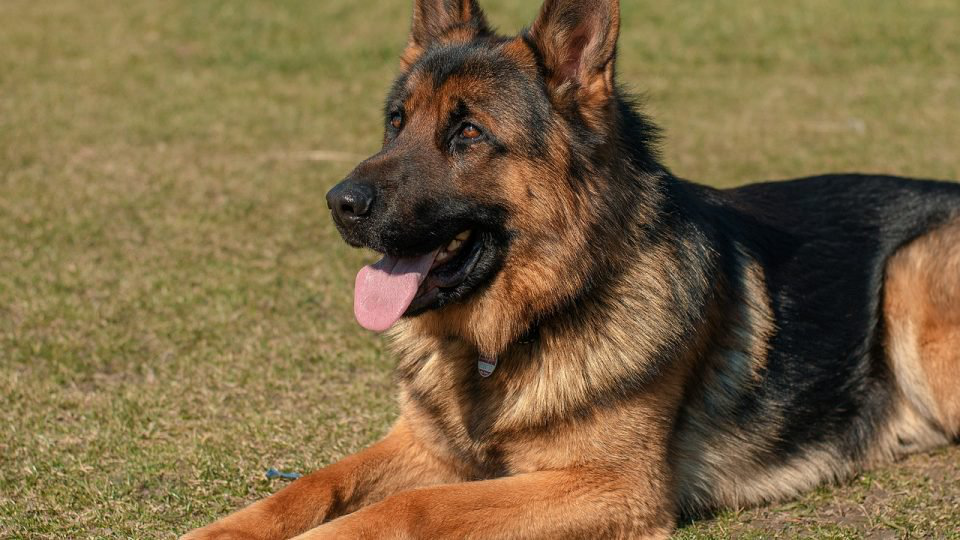

In [6]:
Image.open('dog1.jpg')

In [5]:
img = Image.open('dog1.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: German_shepherd ( 0.992397129535675 )


The prediction seems correct but we can't be sure yet that the model learned what a dog looks like. To be sure we will use `General Attribution` methods that will help us to get an understanding of what the model is looking for when making a certain prediction.

We will start with Integrated Gradients which represents the integral of gradients with respect to an input along the path of a baseline to the input.

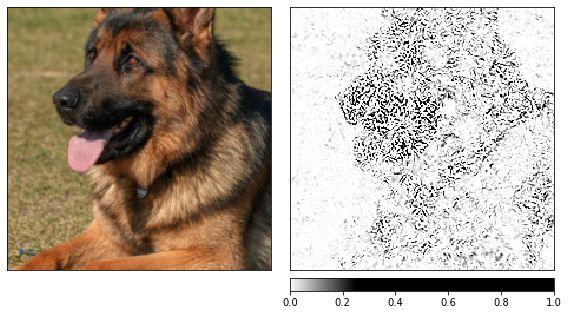

In [7]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

The above result gives us a rough idea but we can get an even better image by smoothing the output using a noise tunnel.

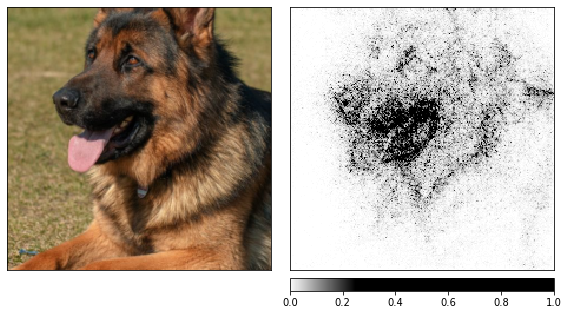

In [8]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

In the above images, we can see that the model heavily focuses on the head of the dog which is reasonable (at least for me).

Another great method for gaining insight about the global behavior is GradientShap, which is a gradient method to compute [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html) values.

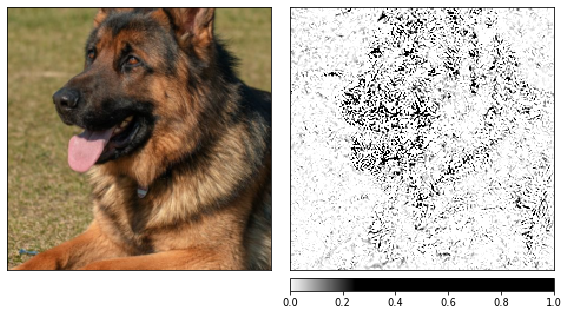

In [9]:
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 255])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

In [ ]:
!python3 -m captum.insights.example


Fetch data and view Captum Insights at http://localhost:50116/

100%|███████████████████████▉| 170352640/170498071 [00:43<00:00, 3044596.51it/s]Extracting data/test/cifar-10-python.tar.gz to data/test
170500096it [01:00, 3044596.51it/s]                                             